In [1]:
import torchvision.models as models
import torch
from torchvision import transforms
from PIL import Image
from torch.nn.utils.rnn import *
from torch import nn
from torch.utils import data
import time
import pdb
from torch.autograd import Variable

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
GPU = torch.cuda.is_available()
device = torch.device("cuda" if GPU else "cpu")
cuda = torch.cuda.is_available()
num_workers = 0 if cuda else 0
GPU

False

In [3]:
torch.cuda.empty_cache()

# Reading Data

In [4]:
# Image loading hyperparameters
numDataPointsWanted = 33808     # max number is 33808
LOADIMAGES = False              # True if we want to pre-load all images (usually results in MEM errors)

CROPBOX = (0, 200, 640, 480)
IMG_SIZE = (320, 240)

transform = transforms.ToTensor()
root_path = "./"

def load_cropped_resized_image(filename):
    with Image.open(root_path + filename) as img:
         return transform(img.crop(CROPBOX).resize(IMG_SIZE).convert('RGB'))

if LOADIMAGES:
    print("Pre-loading all images..")
    X = np.zeros((numDataPointsWanted, 3, IMG_SIZE[0], IMG_SIZE[1]))
else:
    print("Loading image names only..")
    X = np.zeros((numDataPointsWanted), dtype=object)
Y = np.zeros((numDataPointsWanted, 3))


with open(root_path + "labels.txt") as f:
    start = time.time()
    i = 0
    for line in f:
        [filename, radians, torque, speed] = line.split(' ')

        if LOADIMAGES:
            X[i,:,:,:] = load_cropped_resized_image(filename)
        else:
            X[i] = filename
        Y[i,0] = (((float(radians) * 180.0) / np.pi))
        Y[i,1] = float(torque)
        Y[i,2] = float(speed)
        i += 1
            
        if i == numDataPointsWanted: break
    end = time.time()
    

print("Data loading complete, took", int(end - start), "seconds")
print('# Images loaded: ', len(X))

Loading image names only..
Data loading complete, took 0 seconds
# Images loaded:  33808


In [5]:
#trainX, valX, trainY, valY = train_test_split(X, Y, test_size=0.30)
split = int(0.7*len(X))
trainX = X[:split]
valX = X[split:]
trainY = Y[:split]
valY = Y[split:]

# Dataset

In [6]:
class Dataset(data.Dataset):
    def __init__(self, X, Y, seq_len, loaded_images):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
        self.loaded_images = loaded_images
        
    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, index):
        if not self.loaded_images:
            x = np.zeros((self.seq_len, 3, IMG_SIZE[1], IMG_SIZE[0]))
            for i in range(self.seq_len):
                x[i,:,:,:] = load_cropped_resized_image(self.X[index + i])
            return x, self.Y[index + self.seq_len - 1]
        return self.X[index:index + self.seq_len], self.Y[index + self.seq_len - 1]

In [7]:
BATCH_SIZE = 2
SEQ_LEN = 15
num_workers = 0 if cuda else 0

train_set = Dataset(trainX, trainY, SEQ_LEN, LOADIMAGES)
train_dataloader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_set = Dataset(valX, valY, SEQ_LEN, LOADIMAGES)
val_dataloader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

### Example of cropped and resized image

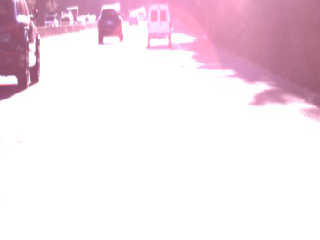

In [8]:
x = train_set.__getitem__(0)[0][0]
x = x.transpose(1, 2, 0)
Image.fromarray((x * 255).astype(np.uint8))

# Our Model


# Convolutional LSTM model, as in the paper 
#   Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting
# https://github.com/automan000/Convolutional_LSTM_PyTorch/blob/master/convolution_lstm.py
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()

        assert hidden_channels % 2 == 0

        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_features = 4

        self.padding = int((kernel_size - 1) / 2)

        self.Wxi = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whi = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxf = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whf = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxc = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Whc = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxo = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=True)
        self.Who = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)

        self.Wci = None
        self.Wcf = None
        self.Wco = None

    def forward(self, x, h, c):
        ci = torch.sigmoid(self.Wxi(x) + self.Whi(h) + c * self.Wci)
        cf = torch.sigmoid(self.Wxf(x) + self.Whf(h) + c * self.Wcf)
        cc = cf * c + ci * torch.tanh(self.Wxc(x) + self.Whc(h))
        co = torch.sigmoid(self.Wxo(x) + self.Who(h) + cc * self.Wco)
        ch = co * torch.tanh(cc)
        return ch, cc

    def init_hidden(self, batch_size, hidden, shape):
        if self.Wci is None:
            self.Wci = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
            self.Wcf = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
            self.Wco = Variable(torch.zeros(1, hidden, shape[0], shape[1])).to(device)
        else:
            assert shape[0] == self.Wci.size()[2], 'Input Height Mismatched!'
            assert shape[1] == self.Wci.size()[3], 'Input Width Mismatched!'
        return (Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device),
                Variable(torch.zeros(batch_size, hidden, shape[0], shape[1])).to(device))


class ConvLSTM(nn.Module):
    # input_channels corresponds to the first input feature map
    # hidden state is a list of succeeding lstm layers.
    def __init__(self, input_channels, hidden_channels, kernel_size, step=1, effective_step=[1]):
        super(ConvLSTM, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.step = step
        self.effective_step = effective_step
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvLSTMCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input):
        internal_state = []
        outputs = []
        for step in range(self.step):
            x = input
            for i in range(self.num_layers):
                # all cells are initialized in the first step
                name = 'cell{}'.format(i)
                if step == 0:
                    bsize, _, height, width = x.size()
                    (h, c) = getattr(self, name).init_hidden(batch_size=bsize, hidden=self.hidden_channels[i],
                                                             shape=(height, width))
                    internal_state.append((h, c))

                (h, c) = internal_state[i]
                x, new_c = getattr(self, name)(x, h, c)
                internal_state[i] = (x, new_c)
            outputs.append(x)

        return outputs, (x, new_c)

In [9]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [10]:
class Whip(nn.Module):
    def __init__(self, in_channels, out_channels, input_size, output_size):
        super(Whip, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3, 12, 12), stride=(1,6,6), padding=(0,1,1))
        self.bn1 = nn.BatchNorm3d(64)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(2, 5, 5), stride=(1,2,2), padding=(0,0,0))
        self.bn2 = nn.BatchNorm3d(64)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(2, 5, 5), stride=(1,1,1), padding=(0,0,0))
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(2, 5, 5), stride=(1,1,1), padding=(0,0,0))
        self.bn4 = nn.BatchNorm3d(64)
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(1, 3, 3), stride=(1,1,1), padding=(0,0,0))
        self.bn5 = nn.BatchNorm3d(64)
        self.relu5 = nn.ReLU()
        
        self.avgpool = nn.AvgPool3d(1)
        
        #self.convLSTM = ConvLSTM(input_channels=out_channels, hidden_channels= [512, 128, 64, 12], kernel_size=3)
        self.convLSTM = ConvLSTM(input_dim=64, hidden_dim=[64,32], kernel_size=(3,3), num_layers=2,
                 batch_first=True, bias=True, return_all_layers=False)
        
        self.fc = nn.Linear(32*8*14, 128)

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)
        
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output) 
        
        output = self.conv4(output)
        output = self.bn4(output)
        output = self.relu4(output)
        
        output = self.conv5(output)
        output = self.bn5(output)
        output = self.relu5(output) #[batch, channels, seq_len, image H, image W]
        
        output = output.permute(0,2,1,3,4) #[batch,seq_len,channels,image H, image W]
        output = self.avgpool(output)
        output, _ = self.convLSTM(output)
        output = output[0]
        
        featuresV = output.reshape((output.shape[0], output.shape[1], -1))
        output = self.fc(featuresV) #[batch,seq_len,features]
        return output

### Prediction Sub-Network

In [11]:
class predictNet(nn.Module):
    def __init__(self, feature_dim=128, hidden_dim=64, out_dim=3, nlayers=3):
        super(predictNet,self).__init__()
        self.lstm = nn.LSTMCell(input_size=feature_dim+out_dim, hidden_size=hidden_dim, bias=False)
        self.fc = nn.Linear(feature_dim+hidden_dim+out_dim, out_dim)
    
    def forward(self, features): 
        predictions = []
        out = torch.zeros((features.shape[0],3)).to(device) #previous speed,torque,angle prediction
        for i in range(features.shape[1]):
            concat1 = torch.cat([features[:,i,:], out], dim=1) #[batch,seq_len,features]
            out_lstm, _ = self.lstm(concat1)
            concat2 = torch.cat([out_lstm, features[:,i,:], out], dim=1)
            out = self.fc(concat2) #[batch,3]
            
            predictions.append(out.unsqueeze(1))
        
        return torch.cat(predictions, dim=1)

In [12]:
class superModel(nn.Module):
    def __init__(self, in_channels, out_channels, input_size, output_size=128, hidden_dim=64, out_dim=3, nlayers=3):
        super(superModel, self).__init__()
        self.whip = Whip(in_channels, out_channels, input_size, output_size).to(device)
        self.predictNet = predictNet().to(device)
    
    def forward(self, x):
        features = self.whip(x)
        predictions = self.predictNet(features.to(device))
        return predictions

In [13]:
def combine(x, y):
    total = 0
    for v in range(len(x)):
        if x[v] and y[v]:
            total += 1
    return total

In [14]:
def train(num_epochs, model, save, optimizer, scheduler, criterion, angle_loss_weight=10.0):
    EPOCH_TRAIN_LOSSES = []
    EPOCH_VAL_LOSSES = []
    EPOCH_TRAIN_ACC = []
    EPOCH_VAL_ACC = []
    train_a_acc = []
    val_a_acc = []
    
    
    for epoch in range(num_epochs):
        start = time.time()

        running_train_loss = 0.0
        running_val_loss = 0.0
        running_train_acc = 0.0
        running_val_acc = 0.0
               
        t_correct_predictions_0_5 = 0.0
        t_correct_predictions_1 = 0.0
        t_correct_predictions_2 = 0.0
        t_correct_predictions_5 = 0.0
        t_correct_predictions_g_5 = 0.0
        
        v_correct_predictions_0_5 = 0.0
        v_correct_predictions_1 = 0.0
        v_correct_predictions_2 = 0.0
        v_correct_predictions_5 = 0.0
        v_correct_predictions_g_5 = 0.0

        model.train()
        for i, (x, label) in enumerate(train_dataloader):
            x, label = x.to(device), label.to(device)
            optimizer.zero_grad()
            x = x.permute(0,2,1,3,4)
            y = model(x.float())[:,-1,:].double().squeeze(1)
            
            loss = criterion(y, label)
#             loss = angle_loss_weight * criterion(y[:,0], label[:,0]) + \
#                                     criterion(y[:,1], label[:,1]) + \
#                                     criterion(y[:,2], label[:,2])
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            predicted_angles = y[0]
            label_angles = label[0]
            running_train_acc += torch.mean(torch.abs(predicted_angles - label_angles)).item()
            t_correct_predictions_0_5 += torch.sum(torch.abs(predicted_angles - label_angles) <= 0.5).item()
            t_correct_predictions_1 += combine(torch.abs(predicted_angles - label_angles) > 0.5,  torch.abs(predicted_angles - label_angles) <= 1)
            t_correct_predictions_2 += combine(torch.abs(predicted_angles - label_angles) > 1,  torch.abs(predicted_angles - label_angles) <= 2)
            t_correct_predictions_5 += combine(torch.abs(predicted_angles - label_angles) > 2,  torch.abs(predicted_angles - label_angles) <= 5)
            v_correct_predictions_g_5 += torch.sum(torch.abs(predicted_angles - label_angles) > 5).item()
            
            del x
            del label

        train_a_a = [t_correct_predictions_0_5, t_correct_predictions_1, t_correct_predictions_2, t_correct_predictions_5, t_correct_predictions_g_5]
        train_a_acc.append(train_a_a)

        model.eval()
        with torch.no_grad():
            for i, (x, label) in enumerate(val_dataloader):
                x, label = x.to(device), label.to(device)
                x = x.permute(0,2,1,3,4)
                y = model(x.float())[:,-1,:].double().squeeze(1)
                
                loss = criterion(y, label)
#                 loss = angle_loss_weight * criterion(y[:,0], label[:,0]) + \
#                             criterion(y[:,1], label[:,1]) + \
#                             criterion(y[:,2], label[:,2])

                running_val_loss += loss.item()
                predicted_angles = y[0]
                label_angles = label[0]
                running_val_acc += torch.mean(torch.abs(predicted_angles - label_angles)).item()
                v_correct_predictions_0_5 += torch.sum(torch.abs(predicted_angles - label_angles) <= 0.5).item()
                v_correct_predictions_1 += combine(torch.abs(predicted_angles - label_angles) > 0.5,  torch.abs(predicted_angles - label_angles) <= 1)
                v_correct_predictions_2 += combine(torch.abs(predicted_angles - label_angles) > 1,  torch.abs(predicted_angles - label_angles) <= 2)
                v_correct_predictions_5 += combine(torch.abs(predicted_angles - label_angles) > 2,  torch.abs(predicted_angles - label_angles) <= 5)
                v_correct_predictions_g_5 += torch.sum(torch.abs(predicted_angles - label_angles) > 5).item()
                
                del x
                del label
                
            val_a_a = [v_correct_predictions_0_5, v_correct_predictions_1, v_correct_predictions_2, v_correct_predictions_5, v_correct_predictions_g_5]
            val_a_acc.append(val_a_a)
                
        train_acc = running_train_acc / len(train_dataloader)
        val_acc = running_val_acc / len(val_dataloader)
        tloss = running_train_loss / len(train_dataloader)
        vloss = running_val_loss/ len(val_dataloader)

        print("EPOCH", epoch, "\t\tTook", int(time.time() - start), "s")
        print("Train Acc:", round(train_acc, 4), "\tVal Acc:", round(val_acc, 4))
        print("Avg Train Loss:", round(tloss, 4), "\tAvg Val Loss:", round(vloss, 4))
        print("===================================================================")

        scheduler.step(vloss)

        EPOCH_TRAIN_LOSSES.append(tloss)
        EPOCH_VAL_LOSSES.append(vloss)
        EPOCH_TRAIN_ACC.append(train_acc)
        EPOCH_VAL_ACC.append(val_acc)

        if save:
            torch.save(model.state_dict(), './model_' + str(epoch + 1) + '_' + str(val_acc) + '.pt')
            
    return EPOCH_TRAIN_LOSSES, EPOCH_VAL_LOSSES, EPOCH_TRAIN_ACC, EPOCH_VAL_ACC, val_a_acc, train_a_acc

for i, (x, label) in enumerate(train_dataloader):
    x, label = x.to(device), label.to(device)
    optimizer.zero_grad()
    y = model(x.float())[:,-1,:].double().squeeze(1)

    loss = criterion(y, label)
    import pdb; pdb.set_trace()

In [15]:
context_size = 15
out_channels = 13
# input_size = 140448     # use this if using original image size
input_size = 27*37

# we will be predicting angle, torque, and speed
output_size = 128
#model = Whip(context_size, out_channels, input_size, output_size).to(device)
model = superModel(in_channels=context_size, out_channels=out_channels, input_size=input_size, output_size=128, hidden_dim=64, out_dim=3, nlayers=3)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
criterion = nn.MSELoss()

print(model)

superModel(
  (whip): Whip(
    (conv1): Conv3d(3, 64, kernel_size=(3, 12, 12), stride=(1, 6, 6), padding=(0, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv3d(64, 64, kernel_size=(2, 5, 5), stride=(1, 2, 2))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv3d(64, 64, kernel_size=(2, 5, 5), stride=(1, 1, 1))
    (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (conv4): Conv3d(64, 64, kernel_size=(2, 5, 5), stride=(1, 1, 1))
    (bn4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU()
    (conv5): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1))
    (bn5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu5): ReLU()
    (avgpool): AvgPool3d(kernel_size=1, stride=1, pa

In [16]:
EPOCH_TRAIN_LOSSES = []
EPOCH_VAL_LOSSES = []
EPOCH_TRAIN_ACC = []
EPOCH_VAL_ACC = []
val_a_acc = []
train_a_acc = []

In [ ]:
n_epochs = 5
results = train(n_epochs, model, False, optimizer, scheduler, criterion)
EPOCH_TRAIN_LOSSES += results[0]
EPOCH_VAL_LOSSES += results[1]
EPOCH_TRAIN_ACC += results[2]
EPOCH_VAL_ACC += results[3]
val_a_acc += results[4]
train_a_acc += results[5]

EPOCH 0 		Took 187 s
Train Acc: 2.3617 	Val Acc: 8.0695
Avg Train Loss: 18.4793 	Avg Val Loss: 103.1719
EPOCH 1 		Took 286 s
Train Acc: 0.4186 	Val Acc: 7.7344
Avg Train Loss: 0.3177 	Avg Val Loss: 99.7523
EPOCH 2 		Took 288 s
Train Acc: 0.3789 	Val Acc: 7.8414
Avg Train Loss: 0.2733 	Avg Val Loss: 102.4805


# Plotting Results

In [ ]:
import matplotlib.pyplot as plt

ep = np.arange(n_epochs)

rangeVi = 0
rangeVf = n_epochs
plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_LOSSES[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_LOSSES[rangeVi:rangeVf], label="Validation")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.savefig('LossGraph.png')
plt.show()

plt.plot(ep[rangeVi:rangeVf], EPOCH_TRAIN_ACC[rangeVi:rangeVf], label="Train")
plt.plot(ep[rangeVi:rangeVf], EPOCH_VAL_ACC[rangeVi:rangeVf], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Average Degree Distance")
plt.title("Epochs vs Average Degree Distance")
plt.legend()
plt.savefig('AccuracyGraph.png')
plt.show()

In [ ]:

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[-1]
performanceT = train_a_acc[0]

x = np.arange(len(objects))
width = 0.2 # the width of the bars
ylim= 300#10000

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for Last Epoch')
ax.set_xticks(x)
plt.ylim(0, ylim)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('Last_Epoch.png', dpi=300)

objects = ('[0, 0.5]', '(0.5, 1]', '(1, 2]', '(2, 5]', '(5, Inf.)')
performanceV = val_a_acc[0]
performanceT = train_a_acc[-1]

x = np.arange(len(objects))
# print(v_all_a)
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, performanceV, width, label="Validation")
rects1 = ax.bar(x + width/2, performanceT, width, label="Training")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Training Points')
ax.set_title('Accuracy for First Epoch')
ax.set_xticks(x)
plt.ylim(0, ylim)
labels = []
totalV = sum(performanceV)
totalT = sum(performanceT)

for x in range(len(objects)):
    labels.append(objects[x] + "\n" + str(int((performanceV[x]/totalV)*100)) + "%," + str(int((performanceT[x]/totalT)*100)) + "%")
ax.set_xticklabels(labels)
ax.legend()
plt.show()
plt.savefig('Zero_Epoch.png', dpi=300)


In [ ]:
torch.save(model.state_dict(), "superModel.pt")